In [31]:
!nvidia-smi

Wed Mar  3 11:25:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |  14828MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 706kB 20.9MB/s 


In [3]:
!wget http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip

--2021-03-03 10:31:38--  http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip [following]
--2021-03-03 10:31:38--  https://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333074849 (318M) [application/zip]
Saving to: ‘camera_scene_detection_train.zip’

camera_scene_detect 100%[===================>] 317.64M  30.8MB/s    in 11s     

2021-03-03 10:31:50 (28.6 MB/s) - ‘camera_scene_detection_train.zip’ saved [333074849/333074849]



In [4]:
!unzip camera_scene_detection_train.zip

Streaming output truncated to the last 5000 lines.
  inflating: training/23_Fireworks/60.jpg  
  inflating: training/23_Fireworks/61.jpg  
  inflating: training/23_Fireworks/62.jpg  
  inflating: training/23_Fireworks/63.jpg  
  inflating: training/23_Fireworks/64.jpg  
  inflating: training/23_Fireworks/65.jpg  
  inflating: training/23_Fireworks/66.jpg  
  inflating: training/23_Fireworks/67.jpg  
  inflating: training/23_Fireworks/68.jpg  
  inflating: training/23_Fireworks/69.jpg  
  inflating: training/23_Fireworks/7.jpg  
  inflating: training/23_Fireworks/70.jpg  
  inflating: training/23_Fireworks/71.jpg  
  inflating: training/23_Fireworks/72.jpg  
  inflating: training/23_Fireworks/73.jpg  
  inflating: training/23_Fireworks/74.jpg  
  inflating: training/23_Fireworks/75.jpg  
  inflating: training/23_Fireworks/76.jpg  
  inflating: training/23_Fireworks/77.jpg  
  inflating: training/23_Fireworks/78.jpg  
  inflating: training/23_Fireworks/79.jpg  
  inflating: training/23_F

In [1]:
from imutils import paths
from pprint import pprint
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import time

# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

In [2]:
# Fix the random seeds
np.random.seed(42)

In [3]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
image_paths[:5]

['training/2_Group_portrait/308.jpg',
 'training/14_Architecture/278.jpg',
 'training/30_Computer_Screens/252.jpg',
 'training/4_Dog/129.jpg',
 'training/9_Mountain/11.jpg']

In [4]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '22_Stage_concert': 322,
         '16_Blue_Sky': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


In [5]:
IMAGE_SIZE = "> 96 x 96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 260
  CROP_TO = 224
else:
  RESIZE_TO = 260
  CROP_TO = 224

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [10]:
# IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
# DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

# if IMAGE_SIZE == "=<96x96 px":
#   RESIZE_TO = 160
#   CROP_TO = 128
# else:

# RESIZE_TO = 224
# CROP_TO = 224

# if DATASET_SIZE == "<20k examples":
# SCHEDULE_LENGTH = 500
# SCHEDULE_BOUNDARIES = [200, 300, 400]
# elif DATASET_SIZE == "20k-500k examples":
#   SCHEDULE_LENGTH = 10000
#   SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
# else:
#   SCHEDULE_LENGTH = 20000
#   SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [6]:
TRAIN_SPLIT = 0.9
IMG_SIZE = 224
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
EPOCHS = 150

In [7]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

8907 990


In [8]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[21  4 22 24 29]


In [9]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 64
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

# STEPS_PER_EPOCH = 36
  
@tf.function
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) /255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))

train_ds = (
    train_ds
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))
val_ds = (
    val_ds
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [12]:
trainLabels = to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

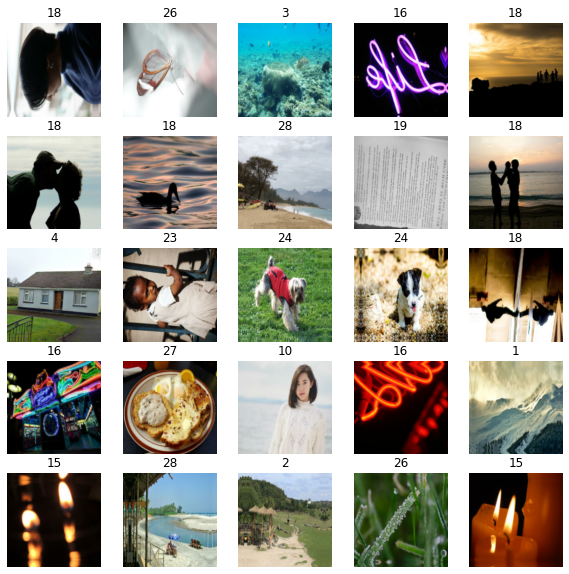

In [13]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis('off')

In [15]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = Sequential([hub.KerasLayer(model_url, trainable=True)])

In [16]:
EPOCHS

150

In [17]:
# class MyBiTModel(tf.keras.Model):
#   def __init__(self, module):
#     super().__init__()
#     self.dense1 = tf.keras.layers.Dense(128)
#     self.normalize = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))
#     self.bit_model = module
  
#   def call(self, images):
#     bit_embedding = self.bit_model(images)
#     dense1_representations = self.dense1(bit_embedding)
#     return self.normalize(dense1_representations)

class MyBiTModel(tf.keras.Model):

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = GlobalAveragePooling2D()
    self.head = Dense(512, activation="relu")

    self.head = Dropout(0.5)

    self.head = Dense(num_classes, activation="softmax", dtype="float32")
    self.bit_model = module

  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

In [18]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [19]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5, restore_best_weights=True)
]

In [20]:
def plot_training(H, embedding_dim):
    with plt.xkcd():
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
        plt.title("Embedding dim: {}".format(embedding_dim))
        plt.legend(loc="lower left")
        plt.show()

Epoch 1/100
140/140 [==============================] - 198s 1s/step - loss: 2.3614 - accuracy: 0.7070 - val_loss: 0.8129 - val_accuracy: 0.7828
Epoch 2/100
140/140 [==============================] - 174s 1s/step - loss: 0.5861 - accuracy: 0.8852 - val_loss: 0.1715 - val_accuracy: 0.9424
Epoch 3/100
140/140 [==============================] - 172s 1s/step - loss: 0.1354 - accuracy: 0.9723 - val_loss: 0.1542 - val_accuracy: 0.9545
Epoch 4/100
140/140 [==============================] - 174s 1s/step - loss: 0.1216 - accuracy: 0.9757 - val_loss: 0.1540 - val_accuracy: 0.9545
Epoch 5/100
140/140 [==============================] - 173s 1s/step - loss: 0.1215 - accuracy: 0.9728 - val_loss: 0.1538 - val_accuracy: 0.9545
Epoch 6/100
140/140 [==============================] - 173s 1s/step - loss: 0.1279 - accuracy: 0.9736 - val_loss: 0.1536 - val_accuracy: 0.9545
Epoch 7/100
140/140 [==============================] - 175s 1s/step - loss: 0.1224 - accuracy: 0.9740 - val_loss: 0.1533 - val_accuracy:

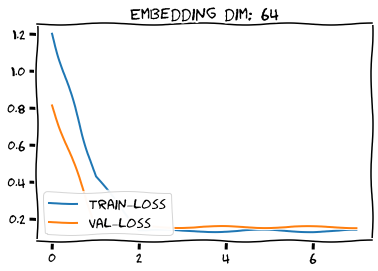

16/16 [==============================] - 6s 357ms/step - loss: 0.1542 - accuracy: 0.9545
Accuracy: 95.45%
INFO:tensorflow:Assets written to: bit_image_scene_v2/assets


INFO:tensorflow:Assets written to: bit_image_scene_v2/assets


In [21]:
model = MyBiTModel(num_classes=30,module=module)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

start = time.time()
history = model.fit(
    train_ds,
    batch_size=64,
    epochs= 100,  
    validation_data=val_ds,
    class_weight=classWeight,
    callbacks=train_callbacks)

end = time.time()-start
print("Model takes {} seconds to train".format(end))

plot_training(history, 64)

accuracy = model.evaluate(val_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

model.save('bit_image_scene_v2')

In [22]:
!du -lh bit_image_scene_v2

270M	bit_image_scene_v2/variables
4.0K	bit_image_scene_v2/assets
282M	bit_image_scene_v2


In [27]:
import os
import zipfile
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))
zipf = zipfile.ZipFile('bit_image_scene_v2.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('./bit_image_scene_v2', zipf)
zipf.close()

## Inference

In [28]:
!wget -q https://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_validation.zip
!unzip -qq camera_scene_detection_validation.zip

In [29]:
# https://stackoverflow.com/a/2669120/7636462
def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    # No rescaling since MobileNetV3 internally does it
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

In [31]:
import re 

test_image_paths = sorted_nicely(list(paths.list_images("images")))
print(f"Total test images: {len(test_image_paths)}")

Total test images: 600


In [32]:
test_image_paths[:5]

['images/0.jpg',
 'images/1.jpg',
 'images/2.jpg',
 'images/3.jpg',
 'images/4.jpg']

In [34]:
classifier_model = load_model("/content/drive/MyDrive/bit_image_scene_v2")

test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_ds = (
    test_ds
    .map(preprocess_image)
    .batch(BATCH_SIZE)
)

test_predictions = np.argmax(classifier_model.predict(test_ds), 1)
test_predictions = le.inverse_transform(test_predictions)
print(test_predictions.shape)

(600,)


In [35]:
test_predictions_num = list(map(lambda x: x.split("_")[0], test_predictions.tolist()))
print(test_predictions_num[:5])
with open('results.txt', "w") as myfile:
    myfile.write('\n'.join(list(test_predictions_num)))
!head -5 results.txt

['9', '21', '27', '4', '28']
9
21
27
4
28
